In [1]:
import torch
import pandas as pd
import numpy as np
import os
from models import model_init
from data_provider.data_factory import Data_Provider
import matplotlib.pyplot as plt
from utils.task import ahead_task_parser
from utils.tools import dotdict
import yaml, json

In [2]:
model = 'PatchTST'
data = 'solar'
ahead = 'day'
version = 'latest'
ckpt_base = './checkpoints/solar'

ckpt_id = f'_{model}_{data}_{ahead}_ahead'

if version == 'latest':
    # find all the path that end with the ckpt_id
    ckpt_paths = [os.path.join(ckpt_base, i) for i in os.listdir(ckpt_base) if i.endswith(ckpt_id)]
    # the path is in format of yyyy-mm-dd{ckpt_id}, now find the latest one
    ckpt_paths.sort()
    ckpt_path = ckpt_paths[-1]
else:
    ckpt_path = version + ckpt_id

config = dotdict(json.load(open(os.path.join(ckpt_path, 'args.json'))))
config.model_config = dotdict(config.model_config)
config.data_config = dotdict(config.data_config)

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.batch_size = 1

In [3]:
model_TST = model_init(config.model, config.model_config, config).to(config.device)
# load the model
model_TST.load_state_dict(torch.load(os.path.join(ckpt_path, 'checkpoint.pth'))) 
model_TST.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 8))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=16, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=16, out_features=16, bias=True)
              (W_K): Linear(in_features=16, out_features=16, bias=True)
              (W_V): Linear(in_features=16, out_features=16, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=16, out_features=16, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.3, inplace=False)
      

In [4]:
model = 'TGTSF'
data = 'solar'
ahead = 'day'
version = 'latest'#'04-16-0316'#'latest'
ckpt_base = './checkpoints/'#+data

ckpt_id = f'_{model}_{data}_{ahead}_ahead'

if version == 'latest':
    # find all the path that end with the ckpt_id
    ckpt_paths = [os.path.join(ckpt_base, i) for i in os.listdir(ckpt_base) if i.endswith(ckpt_id)]
    # the path is in format of yyyy-mm-dd{ckpt_id}, now find the latest one
    ckpt_paths.sort()
    ckpt_path = ckpt_paths[-1]
else:
    ckpt_path = version + ckpt_id
    ckpt_path = os.path.join(ckpt_base, ckpt_path)

config = dotdict(json.load(open(os.path.join(ckpt_path, 'args.json'))))
config.model_config = dotdict(config.model_config)
config.data_config = dotdict(config.data_config)

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.batch_size = 1
print(ckpt_path)

./checkpoints/04-25-0548_TGTSF_solar_day_ahead


In [5]:
model_TGTSF = model_init(config.model, config.model_config, config).to(config.device)
# load the model
model_TGTSF.load_state_dict(torch.load(os.path.join(ckpt_path, 'checkpoint.pth')))
model_TGTSF.eval()

Model(
  (TS_encoder): TS_encoder(
    (attentions): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (input_encoder): Linear(in_features=8, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.3, inplace=False)
  )
  (text_encoder): text_encod

In [6]:
id_data = Data_Provider(config)
fullsets = id_data.get_test('set')
print(fullsets.keys())

[ info ] Successfully load the dynamic data embedding from fast_general_formal_embeddings_????.pkl


Loading test datasets: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

dict_keys(['314106', '319086', '164440', '355827', '331901', '332785', '577650', '551172', '570079'])


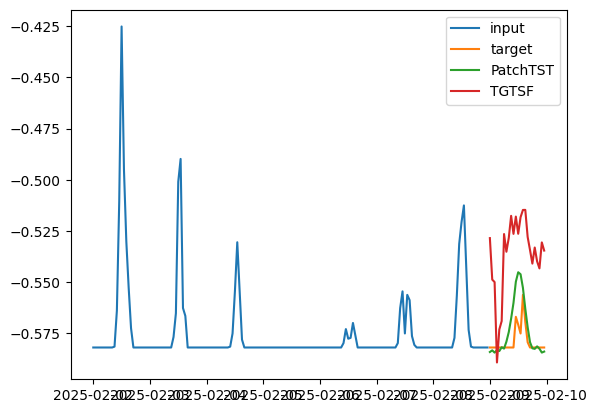

In [63]:
sample_num = 27072
batch_x, batch_y, timestamp_x, timestamp_y, batch_x_hetero, batch_y_hetero, hetero_x_time, hetero_y_time, hetero_general, hetero_channel = fullsets['332785'][sample_num]

batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(config.device)
batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(config.device)
batch_y_hetero = torch.tensor(batch_y_hetero).unsqueeze(0).float().to(config.device)
hetero_channel = torch.tensor(hetero_channel).unsqueeze(0).float().to(config.device)

output_TST = model_TST(x=batch_x)
output_TST = output_TST[:, -config.output_len:, :]

output_TGTSF = model_TGTSF(x=batch_x, historical_events =batch_x_hetero, news = batch_y_hetero, dataset_description=hetero_general, channel_description=hetero_channel)
output_TGTSF = output_TGTSF[:, -config.output_len:, :]



indate = [str(i) for i in timestamp_x]
outdate = [str(i) for i in timestamp_y]
# convert the yyyymmddHHMMSS to datetime
indate = pd.to_datetime(indate, format='%Y%m%d%H%M%S')
outdate = pd.to_datetime(outdate, format='%Y%m%d%H%M%S')
# reformat the indate as datetime
# plot the result
# enable inline plotting
%matplotlib inline
plt.plot(indate, batch_x.cpu().detach().numpy().squeeze(), label='input')
plt.plot(outdate, batch_y.cpu().detach().numpy().squeeze(), label='target')
plt.plot(outdate, output_TST.cpu().detach().numpy().squeeze(), label='PatchTST')
plt.plot(outdate, output_TGTSF.cpu().detach().numpy().squeeze(), label='TGTSF')
plt.legend()

In [37]:
selectset = '332785'
losslist = {}
for sample_num in range(0, len(fullsets[selectset]), 24):
    batch_x, batch_y, timestamp_x, timestamp_y, batch_x_hetero, batch_y_hetero, hetero_x_time, hetero_y_time, hetero_general, hetero_channel = fullsets[selectset][sample_num]

    batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(config.device)
    batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(config.device)
    batch_y_hetero = torch.tensor(batch_y_hetero).unsqueeze(0).float().to(config.device)
    hetero_channel = torch.tensor(hetero_channel).unsqueeze(0).float().to(config.device)

    output_TST = model_TST(x=batch_x)
    output_TST = output_TST[:, -config.output_len:, :]

    output_TGTSF = model_TGTSF(x=batch_x, historical_events =batch_x_hetero, news = batch_y_hetero, dataset_description=hetero_general, channel_description=hetero_channel)
    output_TGTSF = output_TGTSF[:, -config.output_len:, :]

    # calculate the loss
    loss_TST = torch.nn.MSELoss()(output_TST, batch_y)
    loss_TGTSF = torch.nn.MSELoss()(output_TGTSF, batch_y)
    loss_mutual = torch.nn.MSELoss()(output_TST, output_TGTSF)
    losslist[sample_num] = {
        'loss_TST': loss_TST.item(),
        'loss_TGTSF': loss_TGTSF.item(),
        'loss_mutual': loss_mutual.item(),
    }


In [ ]:
def get_lossdf()

In [38]:
# convert to pandas df
lossdf = pd.DataFrame(losslist).T
lossdf

,loss_TST,loss_TGTSF,loss_mutual
0,1.350043e-05,0.001728,0.001854
24,8.901092e-07,0.012688,0.012616
48,3.875039e-06,0.006960,0.006910
72,1.336179e-01,0.098900,0.004955
96,4.242764e-03,0.154650,0.122158
...,...,...,...
27408,6.407602e-01,0.140657,0.247824
27432,3.873941e-01,0.127128,0.157481
27456,2.623532e-01,0.075915,0.109401
27480,1.857238e-01,0.053388,0.074093


In [39]:
# add a column to the df with the sample_num
lossdf['loss_mutual'] = (lossdf.loss_TST-lossdf.loss_TGTSF)/lossdf.loss_TST

In [40]:
# sort the df by loss_TST
lossdf = lossdf.sort_values(by='loss_mutual', ascending=False)
lossdf

,loss_TST,loss_TGTSF,loss_mutual
9816,3.130538e-01,0.001745,0.994427
25080,3.024316e-01,0.001973,0.993476
19296,3.811160e-01,0.003265,0.991434
9840,2.088227e-01,0.001833,0.991224
9096,3.442448e-01,0.003395,0.990137
...,...,...,...
25320,5.209364e-08,0.001750,-33596.385014
25368,5.209364e-08,0.001774,-34049.421053
25344,5.209364e-08,0.001775,-34065.616155
17832,4.125366e-08,0.001664,-40326.600541


In [41]:
# average loss
lossdf.mean()


loss_TST         0.238918
loss_TGTSF       0.151082
loss_mutual   -394.026704
dtype: float64

In [56]:
sum(lossdf.loss_mutual>0.9)

165

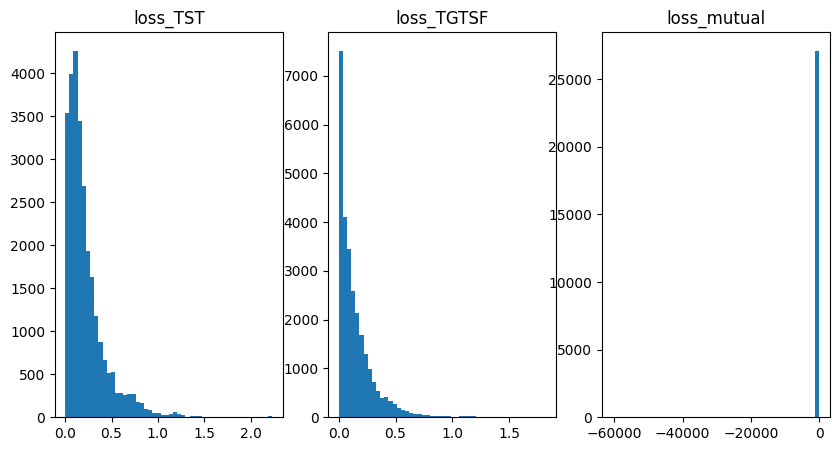

In [35]:
# plot the distribution of these losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.hist(lossdf['loss_TST'], bins=50)
plt.title('loss_TST')
plt.subplot(1, 3, 2)
plt.hist(lossdf['loss_TGTSF'], bins=50)
plt.title('loss_TGTSF')
plt.subplot(1, 3, 3)
plt.hist(lossdf['loss_mutual'], bins=50)
plt.title('loss_mutual')
plt.show()

In [81]:
def get_reasoning_samples(lossdf):
    lossdf['loss_mutual'] = (lossdf.loss_TST-lossdf.loss_TGTSF)/lossdf.loss_TST
    lossdf_ok = lossdf[lossdf.loss_mutual > -10]
    lossdf_pos = lossdf_ok[lossdf_ok.loss_mutual > 0]
    lossdf_neg = lossdf_ok[lossdf_ok.loss_mutual < 0]
    prob_pos = lossdf_pos['loss_mutual'] / sum(lossdf_pos['loss_mutual'])
    prob_neg = lossdf_neg['loss_mutual'] / sum(lossdf_neg['loss_mutual'])
    sample_num_pos = int(len(lossdf_pos) * 0.1)
    sample_num_neg = int(len(lossdf_neg) * 0.1)
    sample_pos = np.random.choice(lossdf_pos.index, sample_num_pos, p=prob_pos)
    sample_neg = np.random.choice(lossdf_neg.index, sample_num_neg, p=prob_neg)
    samples = np.concatenate((sample_pos, sample_neg))
    return samples.tolist()

In [58]:
sum(lossdf['loss_TST']-lossdf['loss_TGTSF']<0)

347

In [59]:
# get the rows that have loss_TST - loss_TGTSF < 0
lossdf[lossdf['loss_TST']-lossdf['loss_TGTSF']<0].sort_values(by='loss_mutual', ascending=False)

,loss_TST,loss_TGTSF,loss_mutual
4920,1.681360e-01,0.168232,-0.000573
13128,8.036655e-02,0.080427,-0.000758
12552,1.324631e-01,0.132774,-0.002349
3576,2.446195e-01,0.245244,-0.002552
10032,2.042212e-01,0.205076,-0.004184
...,...,...,...
25320,5.209364e-08,0.001750,-33596.385014
25368,5.209364e-08,0.001774,-34049.421053
25344,5.209364e-08,0.001775,-34065.616155
17832,4.125366e-08,0.001664,-40326.600541


In [65]:
# remove the lines that have |loss_mutual| >10
lossdf_ok = lossdf[lossdf['loss_mutual']>-10]
lossdf_pos = lossdf_ok[lossdf_ok['loss_mutual']>0]
lossdf_neg = lossdf_ok[lossdf_ok['loss_mutual']<0]

In [74]:
# do importance sampling over the loss_mutual
prob = lossdf_pos['loss_mutual'] / sum(lossdf_pos['loss_mutual'])
# sample 10% of the data
sample_num = int(len(lossdf_pos) * 0.1)
samples = np.random.choice(lossdf_pos.index, sample_num, p=prob)
samples

array([15336,  4056, 19968, 21744, 23232, 20640, 10872, 22248,  6264,
        8616, 25104, 11760, 15312, 10080, 18456, 23040,  8328, 15888,
       17496, 20952,  6720,  2832, 12528, 18816,   576,   240,  9552,
        5640, 25776, 24408, 10536, 23112,  3408, 19248, 24936, 27456,
       11304,  7152,  4248, 25776, 10464, 13944, 19224,  6216, 13560,
       22824,  4680, 15768, 20880, 24072,  1608, 19512, 26160, 12384,
       13560, 10512, 18648,  6672, 18288,  7536,  6792,  9336, 25032,
        2112, 14904,  7224, 26184, 22896, 23064, 12312, 24408,  7968,
       14616,   456, 19416,  7968, 13608, 22632,  3408, 13680])

In [78]:
prob_neg = lossdf_neg['loss_mutual'] / sum(lossdf_neg['loss_mutual'])
# sample 10% of the data
sample_num = int(len(lossdf_neg) * 0.1)
samples_neg = np.random.choice(lossdf_neg.index, sample_num, p=prob_neg)
samples_neg
# combine the two samples
samples = np.concatenate((samples, samples_neg))
samples = np.unique(samples)

In [80]:
# get the samples rows from the lossdf
lossdf.loc[samples].sort_values(by='loss_mutual', ascending=False)

,loss_TST,loss_TGTSF,loss_mutual
25776,0.102256,0.001153,0.988728
25104,0.135716,0.001674,0.987662
7152,0.191222,0.002740,0.985669
18816,0.201975,0.003413,0.983102
13608,0.644613,0.015216,0.976395
...,...,...,...
9480,0.090610,0.534219,-4.895814
1704,0.195938,1.357213,-5.926759
17088,0.016676,0.119016,-6.136770
27096,0.000212,0.001577,-6.432513


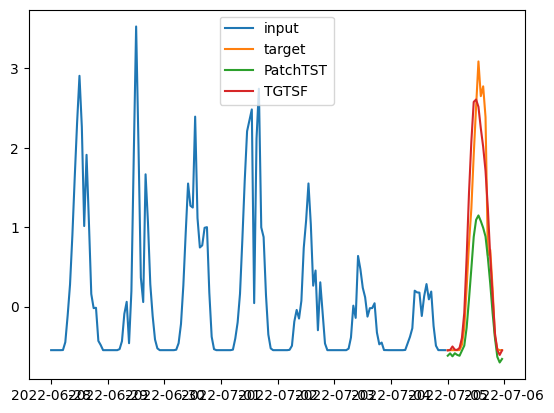

In [64]:
sample_num = 4272#2256#20136
batch_x, batch_y, timestamp_x, timestamp_y, batch_x_hetero, batch_y_hetero, hetero_x_time, hetero_y_time, hetero_general, hetero_channel = fullsets['314106'][sample_num]

batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(config.device)
batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(config.device)
batch_y_hetero = torch.tensor(batch_y_hetero).unsqueeze(0).float().to(config.device)
hetero_channel = torch.tensor(hetero_channel).unsqueeze(0).float().to(config.device)

output_TST = model_TST(x=batch_x)
output_TST = output_TST[:, -config.output_len:, :]

output_TGTSF = model_TGTSF(x=batch_x, historical_events =batch_x_hetero, news = batch_y_hetero, dataset_description=hetero_general, channel_description=hetero_channel)
output_TGTSF = output_TGTSF[:, -config.output_len:, :]



indate = [str(i) for i in timestamp_x]
outdate = [str(i) for i in timestamp_y]
# convert the yyyymmddHHMMSS to datetime
indate = pd.to_datetime(indate, format='%Y%m%d%H%M%S')
outdate = pd.to_datetime(outdate, format='%Y%m%d%H%M%S')
# reformat the indate as datetime
# plot the result
# enable inline plotting
%matplotlib inline
plt.plot(indate, batch_x.cpu().detach().numpy().squeeze(), label='input')
plt.plot(outdate, batch_y.cpu().detach().numpy().squeeze(), label='target')
plt.plot(outdate, output_TST.cpu().detach().numpy().squeeze(), label='PatchTST')
plt.plot(outdate, output_TGTSF.cpu().detach().numpy().squeeze(), label='TGTSF')
plt.legend()